In [1]:
from os.path import join,expanduser
import sys
import cmocean as cmo
# identify user's home directory
user_home_dir = expanduser('~')
# import the ECCOv4 py library 
sys.path.insert(0,join(user_home_dir,'ECCOv4-py'))
import ecco_v4_py as ecco
import botocore
import boto3
from boto3.session import Session
import cmocean
from collections import Counter
from dask.distributed import Client
import datetime
import fsspec
from gc import get_referents
import json
from matplotlib import colors as mcolors
from matplotlib.cm import ScalarMappable
import numpy as np
from pathlib import Path
from pprint import pprint
import requests
import s3fs
import sys
from sys import getsizeof
import time as time
from types import ModuleType, FunctionType
import xarray as xr
import matplotlib.pyplot as plt
import zarr


In [3]:
#1. Create the monthly salinity climatology between 1992-2019
directory = Path('/home/jovyan/efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/OCEAN_TEMPERATURE_SALINITY')
# list sub-directories (one per dataset) 1992 - 2019
ecco_v4r5_mon_mean_native_dataset_paths = np.sort(list(directory.glob('*')))
monthly   = [[] for _ in range(12)]
for i, file_path in enumerate(ecco_v4r5_mon_mean_native_dataset_paths):
    ds        = xr.open_dataset(file_path);
    month_idx = int(ds.time.dt.month.item()) - 1 # Extract month (1–12), convert to index (0–11)
    #ds_tile0 = ds.sel(tile=tilesel) # Select only tile 0 and drop tile dimension
    monthly[month_idx].append(ds)
climon = []
for i in range(0,12):
  print("I am in month",i)
  var     = monthly[i]
  mon_all = xr.concat(var, dim='time')
  monclim = mon_all.mean(dim='time',skipna="True")
  climon.append(monclim)

I am in month 0
I am in month 1
I am in month 2
I am in month 3
I am in month 4
I am in month 5
I am in month 6
I am in month 7
I am in month 8
I am in month 9
I am in month 10
I am in month 11


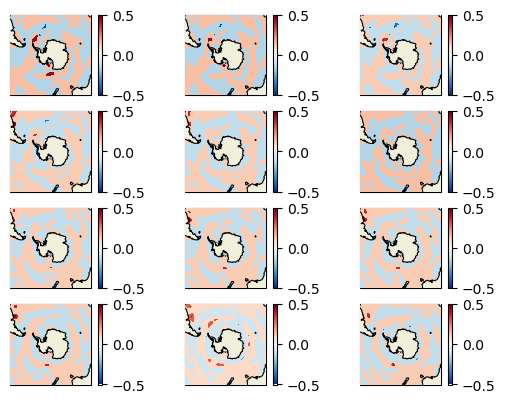

In [4]:
#2. Create the monthly salinity anomalies each year
directory = Path('/home/jovyan/efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/OCEAN_TEMPERATURE_SALINITY')
y         = 2017
ecco_v4r5_mon_mean_native_dataset_paths2 = np.sort(list(directory.glob(f'*{y}-*.nc')))
mon       = [[] for _ in range(12)]
for i, file_path in enumerate(ecco_v4r5_mon_mean_native_dataset_paths2):
    ds        = xr.open_dataset(file_path);
    month_idx = int(ds.time.dt.month.item()) - 1 # Extract month (1–12), convert to index (0–11)
    mon[month_idx].append(ds)
#--- Calculate monthly Salinity anomalies - - - - ##
anomon = []
for i in range(0,12):
  var      = mon[i][0].SALT[0,:,:,:,:]
  climvar  = climon[i].SALT[:,:,:,:]
  TEMPANOM = var - climvar ##the i loops in the months 
  anomon.append(TEMPANOM)

### -------------- MAKE THE SALINITY ANOMALY PLOTS -----------------------------------------
montitles = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
nrow      = 4;ncol= 3;figca  = []
colorm    = cmocean.cm.balance
cmin      = -0.5;cmax=0.5;cstep=0.02
for a in range(0,12):
  var = anomon[a][0,:,:,:]
  ecco.plot_proj_to_latlon_grid(var.XC, var.YC, var, projection_type='stereo',plot_type = 'contourf', show_colorbar=True,dx=1, dy=1,lat_lim=-40,cmin=cmin,cmax=cmax,colormap=colorm,show_coastline=True,show_tile_labels = montitles[a],subplot_grid=[nrow, ncol, a+1]);
plt.savefig(f'/home/jovyan/efs_ecco/sdarma/FIGURES/SALINITY_SO/SO_SALTANOM_{y}_2D.png')


In [9]:
##3. Load the grid file of ECO and find the file with the depth/bottom of each grid cell
ecco_grid = xr.open_dataset('/efs_ecco/ECCO/V4/r4/ECCO_L4_GEOMETRY_LLC0090GRID_V4R4/GRID_GEOMETRY_ECCO_V4r4_native_llc0090.nc')
dep1      = ecco_grid.Zp1
## Now find the difference between the depth/bottom of each grid cell to calculate grid cell thickness
dz        = np.abs(np.diff(dep1))
dz.shape

(50,)

In [14]:
##4.Extract the first 20 layers of thickness and multiply with the salinity (of 2017) in the first 20 layers of depth to properly calculate salinity concentration
dz_da   = xr.DataArray(dz[0:20], dims=["k"])
var     = dz_da[0:20]*mon[i][0].SALT[0,0:20,:,:,:]
## Do the same for the monthly climatological files of salinity
climvar = dz_da[0:20]*climon[i].SALT[0:20,:,:,:]
## Final monthly concentration of salinity, summed over the upper 20 layers
var2    = (dz_da[0:20]*mon[i][0].SALT[0,0:20,:,:,:]).sum(dim=["k"])
var2.shape

(13, 90, 90)

In [15]:
##5. Calculate the monthly salinity anomaly each year
directory = Path('/home/jovyan/efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/OCEAN_TEMPERATURE_SALINITY')
y   = 2017
ecco_v4r5_mon_mean_native_dataset_paths2 = np.sort(list(directory.glob(f'*{y}-*.nc')))
mon = [[] for _ in range(12)]
for i, file_path in enumerate(ecco_v4r5_mon_mean_native_dataset_paths2):
    ds        = xr.open_dataset(file_path);
    month_idx = int(ds.time.dt.month.item()) - 1 # Extract month (1–12), convert to index (0–11)
    mon[month_idx].append(ds)
# Calculate the salinity anomaly #
anomon = []
dz_da  = xr.DataArray(dz[0:20], dims=["k"])
for i in range(0,12):
  var      = (dz_da[0:20]*mon[i][0].SALT[0,0:20,:,:,:]).sum(dim=["k"])
  climvar  = (dz_da[0:20]*climon[i].SALT[0:20,:,:,:]).sum(dim=["k"])
  SALANOM  = var - climvar ##the i loops in the months 
  anomon.append(SALANOM)


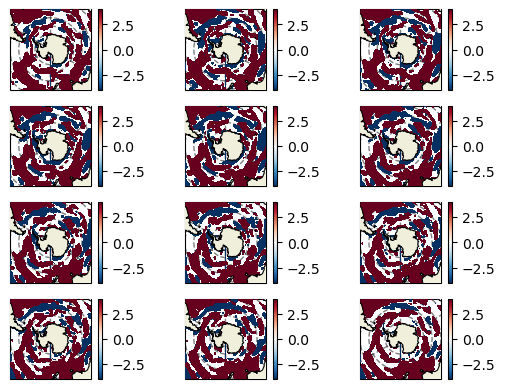

In [16]:
#6. Plot the salinity anomaly of 2017
montitles = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
nrow      = 4;ncol =3 
colorm    = cmocean.cm.balance
for a in range(0,12):
  var = anomon[a][:,:,:]
  ecco.plot_proj_to_latlon_grid(var.XC, var.YC, var, projection_type='stereo',plot_type = 'contourf', show_colorbar=True,dx=1, dy=1,lat_lim=-40,cmin=-4,cmax=4,colormap=colorm,show_coastline=True,show_tile_labels = montitles[a],subplot_grid=[nrow, ncol, a+1]);